<a href="https://colab.research.google.com/github/aim56009/AI-MA_project/blob/main/Visuals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataloading

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!pip install nltools
!pip install nilearn

%cd "/content/gdrive/MyDrive/Masterarbeit"
%pylab inline

In [2]:
import torch
from torch.utils.data.dataset import Dataset
import glob
import numpy as np
import os
import nibabel as nib
from scipy.ndimage import zoom

In [3]:
def saveResampledNifti(generatedData64, imgREF, fNameOut):
    dims = imgREF.shape
    generatedDataOrgRes = zoom(generatedData64, (dims[0]/64, dims[1]/64, dims[2]/64))
    imgRes = nib.Nifti1Image(generatedDataOrgRes, affine = imgREF.affine)
    nib.save(imgRes, fNameOut)

In [4]:
# MAY WANT TO ADD A RANDOM GENERATOR SEED FOR REPRODUCIBILITY HERE
def generate_fake(generator, z_dim, output_dir, n_fakes=100, batch_size=1):
  from tqdm.notebook import tqdm  # a nice waitbar for notebooks

  print('saving into %s' % output_dir)
  for k in tqdm(range(n_fakes)):

      noise = torch.randn(batch_size, z_dim, 1, 1, 1).to(device)
      dat = generator(noise)

      fNameOut = os.path.join(output_dir,'fake'+'{:03}'.format(k+1) + '.nii.gz')
      generatedData64 = np.squeeze(dat.data.cpu().numpy())
      saveResampledNifti(generatedData64, imgREF, fNameOut)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
CHANNELS_IMG = 1
Z_DIM = 1000
FEATURES_GEN = 32
BATCH_SIZE = 4
ITER = 100

from model_wgan_gp_tanh import Discriminator, Generator, initialize_weights

In [6]:
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)

# adapt this name for one of the checkpoints in "checkpoint_models"
model_name = 'b%d_z%d_gen_iter%06d' %(BATCH_SIZE, Z_DIM, ITER)  
#gen.load_state_dict(torch.load("checkpoint_models/%s.pth" % model_name))

### for loading in a further special folder
model_name = "ckpt_gen_iter000100"
gen.load_state_dict(torch.load("checkpoint_models/footright_tanh/%s.pth" % model_name))

<All keys matched successfully>

In [7]:
PATH_TO_DATA="/content/gdrive/MyDrive/Masterarbeit/tstat_0mm"

class RealDataset(Dataset):

    def __init__(self, data_dir, labels, n, transforms=None):
        self.transforms = transforms
        self.mask = np.load("mask_dil64.npy")
        # get the files
        for iLabel in range(len(labels)):
            file_names = sorted(glob.glob(os.path.join(data_dir, labels[iLabel], "*.nii.gz")))

            if iLabel == 0:
                self.data = np.array(file_names[:n])
                self.labels = np.array(np.repeat(labels[iLabel], len(self.data)))
            else:
                self.data = np.append(self.data, file_names[:n])
                self.labels = np.append(self.labels, np.repeat(labels[iLabel], len(self.data)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        img = np.nan_to_num(nib.load(self.data[idx]).get_fdata())  
        img[np.isnan(img)] = 0

        dims = img.shape
        img_ = zoom(img, (64/dims[0], 64/dims[1], 64/dims[2]))

        img_ = (img_-np.min(img_))/(np.max(img_)-np.min(img_))
        img_ = 2*img_-1

        mask_img = img_ * self.mask

        mask_img = torch.tensor(mask_img)
        mask_img = mask_img.unsqueeze(0)
        


        sample = {'img': mask_img.float(), 'label': self.labels[idx]}
        return sample

In [8]:
dataset = RealDataset(PATH_TO_DATA, ["footright"], 100)  #802

In [9]:
loader = torch.utils.data.DataLoader(dataset,batch_size=100, shuffle=False, num_workers=0, drop_last=True)

# Compute SSIM for 100 real VS 100 fakes

In [10]:
noise = torch.randn(100, Z_DIM, 1, 1, 1).to(device)
run = gen(noise).detach().cpu().numpy()
avg_fake = np.sum(run,axis=0).squeeze()/100 

In [11]:
for batch_idx, real in enumerate(loader):
    real = real["img"].detach().cpu().numpy()
avg_real = np.sum(real,axis=0).squeeze()/100 

In [13]:
PROJECT_DIR = "."

#PATH_CHECKPOINT_IMG = os.path.join(PROJECT_DIR, 'checkpoint_images', model_name)
#if not os.path.exists(PATH_CHECKPOINT_IMG):
#  os.mkdir(PATH_CHECKPOINT_IMG)

imgREF = nib.load(os.path.join(PROJECT_DIR, 'tstat_' + '0mm', ['handleft'][0], 'sub100307.nii.gz'))

In [16]:
from skimage.metrics import structural_similarity as ssim
ssim_const = ssim(avg_real, avg_fake,data_range=avg_fake.max() - avg_fake.min())


print("ssim for current activation function:",ssim_const)

print("ssim ReLU:","0.7655")
print("ssim leaky Relu:","0.8673")
print("ssim Tanh:","0.8866"  )
print("ssim ReLU after training for 1 epoch:","0.1210"  )
print("ssim Tanh 200 epochs:","0.84023"  )
print("ssim Tanh footright:","0.78")

ssim for current activation function: 0.778621041562083
ssim ReLU: 0.7655
ssim leaky Relu: 0.8673
ssim Tanh: 0.8866
ssim ReLU after training for 1 epoch: 0.1210
ssim Tanh 200 epochs: 0.84023
ssim Tanh footright: 0.78


### save avg real-fake samples

In [15]:
#saveResampledNifti(avg_fake,imgREF,"avg_fake_FR.nii.gz")
#saveResampledNifti(avg_real,imgREF,"avg_real_FR.nii.gz")

# Create Matrix

In [17]:
for batch_idx, real in enumerate(loader):
    if batch_idx == 0:
        real_imgs = real["img"]

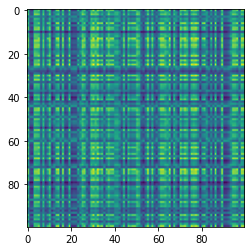

In [46]:
ssim_matrix = np.zeros((100,100))
sum_ssim = 0
real_list = [real_imgs[i].flatten(start_dim=0,end_dim=1).detach().cpu().numpy() for i in range(100)]

for i in range(100):
    noise = torch.randn(1, Z_DIM, 1, 1, 1).to(device)
    generated = gen(noise)
    fa = generated[0].flatten(start_dim=0,end_dim=1).detach().cpu().numpy() 

    for y, re in enumerate(real_list):
        ssim_ = ssim(re, fa,data_range=fa.max() - fa.min())
        ssim_matrix[i,y] = ssim_

plt.imshow(ssim_matrix)

# sort after increasing cols

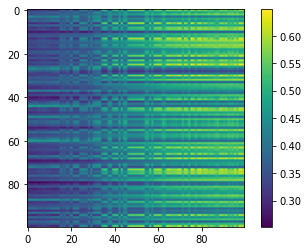

In [47]:
sorted_ssim = ssim_matrix[:,np.argsort(ssim_matrix.sum(axis=0)) ]
plt.imshow(sorted_ssim)
plt.colorbar()

# sort after increasing rows

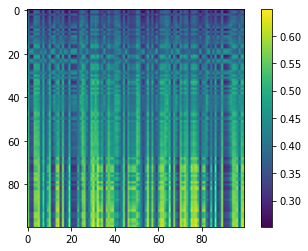

In [48]:
sorted_ssim = ssim_matrix[np.argsort(ssim_matrix.sum(axis=1)),: ]
plt.imshow(sorted_ssim)
plt.colorbar()

# Do it only for 10 

In [ ]:
for batch_idx, real in enumerate(loader):
    if batch_idx == 0:
        real_imgs = real["img"]

<function matplotlib.pyplot.colorbar>

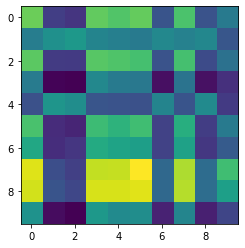

In [36]:
ssim_matrix = np.zeros((10,10))
sum_ssim = 0
real_list = [real_imgs[i].flatten(start_dim=0,end_dim=1).detach().cpu().numpy() for i in range(10)]

for i in range(10):
    noise = torch.randn(1, Z_DIM, 1, 1, 1).to(device)
    generated = gen(noise)
    fa = generated[0].flatten(start_dim=0,end_dim=1).detach().cpu().numpy() 

    for y, re in enumerate(real_list):
        ssim_ = ssim(re, fa,data_range=fa.max() - fa.min())
        ssim_matrix[i,y] = ssim_

plt.imshow(ssim_matrix)
plt.colorbar

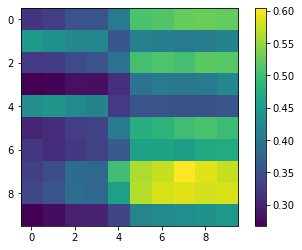

In [43]:
sorted_ssim = ssim_matrix[:,np.argsort(ssim_matrix.sum(axis=0)) ]
plt.imshow(sorted_ssim)
plt.colorbar()

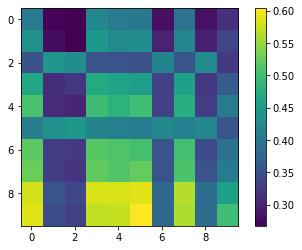

In [45]:
sorted_ssim = ssim_matrix[np.argsort(ssim_matrix.sum(axis=1)),: ]
plt.imshow(sorted_ssim)
plt.colorbar()